https://platform.openai.com/docs/pricing

https://platform.openai.com/settings/profile/api-keys

https://platform.openai.com/settings/organization/billing/overview



# **Recitation 4: Retrieval Augmented Generation (RAG) for MIT Courses**
Written by Evan Yao, Adapted from Lecture 10 Notebook.
![image.png](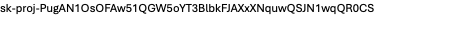![image.png](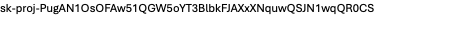![image.png](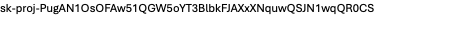![image.png](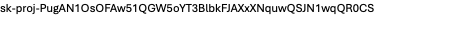![image.png](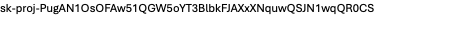![image.png]())))))
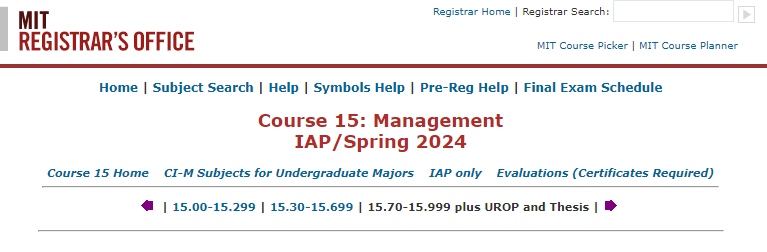


This notebook will demonstrate using Retrieval Augmented Generation (RAG) to answer questions about courses at MIT. Recall how RAG fits in the "Ladder of LLM Adaptation".
* Zero-Shot Learning: Please answer this question purely with the information the model has been trained on.
* Few-Shot Learning: Please answer this question using some custom logic that I provide through a few examples.
* RAG: Provide long paragraphs of text and have the model extract the answers from the text (this notebook)
* Fine-Tuning: Provide labeled examples of how you want the language model to change (e.g. Explain Like I'm 5)

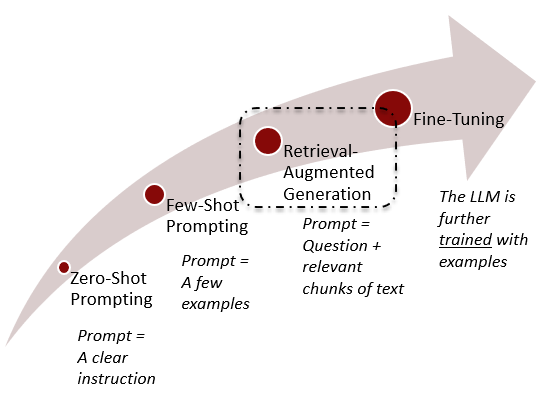

This notebook consists of the following parts:

1. **Scraping the MIT Registrar's Website** - using HTML parsers, we will grab our data and perform some simple cleaning.
2. **Manually Find Relevant Information** - We will pass in to GPT3 chunks of text from the scrapped HTML, but do so manually based on our question.  
3. **Using RAG** - Using RAG, we automatically find the course descriptions that are the most relevant to our question.
4. **RAG + Few Shot Learning** - We answer a more sophisticated question using some examples

This notebook is very similar to the notebook from Lecture 10 [here](https://colab.research.google.com/drive/1VwT3eQFxGJgIfaC8zMjOPohUfSqaPsEB), so we will not be providing a walkthrough of many of the setup procedures as we already did so in that notebook.

# Setup

Let's get started by installing the openai python package and `tiktoken`, a package that can tokenize inputs using BPE, in a manner compatible with the OpenAI models. The setup here is the same as that of Lecture 10. We need to go to the "Secret" tab of colab (on the left sidebar) and add "OPENAI_API_KEY" as the name and the corresponding value that you copied from OpenAI's website. You then need to allow the key notebook access.


In [ ]:
!pip install --upgrade openai
!pip install tiktoken

from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
pd.set_option('display.max_colwidth', 400)
import tiktoken
import os
from google.colab import userdata, drive

# models
EMBEDDING_MODEL = "text-embedding-3-small"
# GPT_MODEL = "gpt-3.5-turbo"
GPT_MODEL = "gpt-4o-mini"
# https://platform.openai.com/docs/pricing
# https://platform.openai.com/settings/profile/api-keys
# https://platform.openai.com/settings/organization/billing/overview

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

# client for OpenAI API
from openai import OpenAI # for calling the OpenAI API
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY", "<your OpenAI API key if not set as env var>"))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 473.5/473.5 kB 11.2 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.61.1
    Uninstalling openai-1.61.1:
      Successfully uninstalled openai-1.61.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 25.3 MB/s eta 0:00:00


In [ ]:
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY", "<your OpenAI API key if not set as env var>"))

# Prompting without custom data

Before we try anything fancy, let's simply ask `gpt-3.5-turbo` a question on MIT Sloan's courses. Recall from class the syntax that we used to query OpenAI's API.

In [ ]:
query = 'Question: Who are the instructors of Hands-On Deep Learning?'
# query = 'Who are the instructors of Hands-On Deep Learning?. Give me an answer or say I dont know'

response = client.chat.completions.create(
    messages=[
        {'role': 'system', 'content': 'You answer questions about courses at the MIT Sloan School of Management.'},
        {'role': 'user', 'content': query},
    ],
    model=GPT_MODEL,
    temperature=0,
)

print(response.choices[0].message.content)

The course "Hands-On Deep Learning" at MIT Sloan is typically taught by a team of instructors, which may include faculty members with expertise in machine learning and artificial intelligence. However, for the most accurate and up-to-date information regarding the specific instructors for the current or upcoming semester, I recommend checking the official MIT Sloan course listings or the course website.


Note that the first message, with `'role': 'system'` may seem a bit strange. It is common practice to set the behavior/tone of the assistant by providing an instruction before any dialogue. See the following quote from OpenAI's API:

> Typically, a conversation is formatted with a system message first, followed by alternating user and assistant messages. The system message helps set the behavior of the assistant. For example, you can modify the personality of the assistant or provide specific instructions about how it should behave throughout the conversation. However note that the system message is optional and the model’s behavior without a system message is likely to be similar to using a generic message such as "You are a helpful assistant."


As you would expect, GPT is not able to answer this question as it is too specific. Sure, GPT knows about some professors at MIT, but it unlikely that the exact MIT course catalog page was used in the training of the model.

In [ ]:
query = 'What course should I take if I want to learn more about deep learning? Please give me the course number.'

response = client.chat.completions.create(
    messages=[
        {'role': 'system', 'content': 'You answer questions about courses at the MIT Sloan School of Management.'},
        {'role': 'user', 'content': query},
    ],
    model=GPT_MODEL,
    temperature=0,
)

print(response.choices[0].message.content)

At MIT Sloan, you can take the course "Artificial Intelligence: Implications for Business Strategy" (course number 15.871) to learn more about deep learning and its applications in business. This course covers various aspects of AI, including deep learning techniques. Additionally, you might also want to explore courses offered by the Electrical Engineering and Computer Science department, such as "Deep Learning for Self-Driving Cars" (course number 6.864) for a more technical focus.


Notice how ChatGPT made up a course that sounds like it exists, but doesn't.

# Scraping the MIT Course Catalog

We will scrape the MIT course catalog for Course 15. There are 3 pages at the following links:

* Page 1 (https://student.mit.edu/catalog/m15a.html)
* Page 2 (https://student.mit.edu/catalog/m15b.html)
* Page 3 (https://student.mit.edu/catalog/m15c.html)

Let's look at how the HTML is structured

In [ ]:
def parse_mit_course_catlog(url):
    response = requests.get(url)

    soup = BeautifulSoup(response.text, "html.parser")
    blocks = []

    for heading in soup.find_all("h3"):  # find separators, in this case h3 nodes

        ## Content that appears as plain text (not enclosed in HTML tags)
        string_values = ""
        for sibling in heading.find_next_siblings(string=True):
            if sibling.name == "h3":
                break
            string_values += sibling.text.strip() + " "

        ## Content that is in HTML tags (e.g. Fall/Spring/IAP, Graduate/Undergraduate, Instructor)
        tag_info = ""
        for sibling in heading.find_next_siblings():
            if sibling.name == "h3":
                break
            if sibling.name == 'img' and sibling.get('height') == '16':
                tag_info += sibling.get('title') + " "

            # Italics text include meeting time (MW8:30-10), instructor
            if sibling.name == 'i':
                tag_info += sibling.text.strip() + " "

        blocks.append({'course_name': heading.text.strip(), 'description': tag_info + " " + string_values})

    return pd.DataFrame(blocks)

parse_mit_course_catlog("https://student.mit.edu/catalog/m15a.html")

,course_name,description
0,15.000 Explorations in Management,"Undergrad Fall J. Orlin ( ) Prereq: None Units: 2-0-1 [P/D/F] Broad introduction to the various aspects of management including analytics, accounting and finance, operations, marketing, entrepreneurship and leadership, organizations, economics, systems dynamics, and negotiation and communication. Introduces the field of management through a variety of experiences as well as discussions led ..."
1,15.002 Leadership Challenges for an Inclusive World,"Graduate Fall Spring TBA Consult: Sloan Educational Services Consult: Sloan Educational Services ( , ) Prereq: None Units arranged [P/D/F] Units assigned to MBA students upon completion. Restricted to Sloan MBA students. Fall: Spring: No textbook information available"
2,15.003 Analytics Tools,"Graduate Fall IAP Summer M. Li M. Li M. Li ( , , ) Prereq: None Units: 2-0-1 [P/D/F] Units assigned to Master of Business Analytics students upon completion of the Analytics Tools requirement. Restricted to Master of Business Analytics students. Fall: IAP: Summer: No textbook information available"
3,15.004 Programming for Finance Professionals,"Graduate Summer B. Vartak ( ) Prereq: None Units: 1-0-0 [P/D/F] Two-day accelerated course with supplemental recitations designed to develop skills in applying basic methods from the programming language Python (with additional references from R) to financial problems. Topics include programming basics in Python, data manipulation, visualization and reporting and an overview of programming ..."
4,15.005 Sloan Intensive Period Elective Requirement,Graduate Spring Consult: Sloan Educational Services ( ); second half of term Prereq: Units arranged [P/D/F] URL: TBA. Units assigned to MBA students upon completion of the Sloan Intensive Period (SIP) elective requirement. Restricted to Sloan MBA students. No textbook information available
...,...,...
96,15.285 Sports Strategy and Analytics,"Graduate Spring T EVE (4-7 PM) B. Shields ( ); second half of term Prereq: None Units: 3-0-3 Begins Mar 31. ( ) Explores how leaders and organizations apply data and analytics to gain a competitive edge in the multibillion-dollar global sports industry. Provides context on the structure and dynamics of the sports industry, discusses best practices in data-driven decision making both on- ..."
97,15.286 Communicating with Data,"Graduate Spring TR10-11.30 (ENDS MAR 14) TR1-2.30 (ENDS MAR 14) MW1-2.30 (ENDS MAR 14) TR10-11.30 (BEGINS MAR 31) TR1-2.30 (BEGINS MAR 31) MW1-2.30 (BEGINS MAR 31) M. Kazakoff, A. Mehrotra ( ); first half of term Prereq: , , or permission of instructor Units: 3-0-3 Credit cannot also be received for , ( ) or ( ) or ( ) or ( ) or ( ) or ( ) Focuses on structuring the oral and visual comm..."
98,15.287 Communication and Persuasion Through Data,"Graduate IAP A. Telio ( ) Prereq: None Units: 2-0-1 Credit cannot also be received for , Focuses on the strategic and tactical use of data to move others to take (the correct) action. Sharpens communication skills via practice and real-world examples. Students spend significant time writing, speaking and designing visuals for a professional audience. Intended for students who expect to com..."
99,15.288 Tough Conversations,"Graduate Fall K. Blackburn ( ) Prereq: None Units: 3-0-3 Equips managers with the knowledge and skills to productively navigate conversations about race, gender, and other aspects of social identities at work. Analyzes the structure of difficult conversations, investigates the research on conversational dynamics, and explores strategies for speaking up in organizations. Significant class ti..."


In [ ]:
urls = [
    "https://student.mit.edu/catalog/m15a.html",
    "https://student.mit.edu/catalog/m15b.html",
    "https://student.mit.edu/catalog/m15c.html",
]

mit_course_data = []

for url in urls:
    mit_course_data.append(parse_mit_course_catlog(url))

mit_course_data = pd.concat(mit_course_data).reset_index(drop=True)
mit_course_data

,course_name,description
0,15.000 Explorations in Management,"Undergrad Fall J. Orlin ( ) Prereq: None Units: 2-0-1 [P/D/F] Broad introduction to the various aspects of management including analytics, accounting and finance, operations, marketing, entrepreneurship and leadership, organizations, economics, systems dynamics, and negotiation and communication. Introduces the field of management through a variety of experiences as well as discussions led ..."
1,15.002 Leadership Challenges for an Inclusive World,"Graduate Fall Spring TBA Consult: Sloan Educational Services Consult: Sloan Educational Services ( , ) Prereq: None Units arranged [P/D/F] Units assigned to MBA students upon completion. Restricted to Sloan MBA students. Fall: Spring: No textbook information available"
2,15.003 Analytics Tools,"Graduate Fall IAP Summer M. Li M. Li M. Li ( , , ) Prereq: None Units: 2-0-1 [P/D/F] Units assigned to Master of Business Analytics students upon completion of the Analytics Tools requirement. Restricted to Master of Business Analytics students. Fall: IAP: Summer: No textbook information available"
3,15.004 Programming for Finance Professionals,"Graduate Summer B. Vartak ( ) Prereq: None Units: 1-0-0 [P/D/F] Two-day accelerated course with supplemental recitations designed to develop skills in applying basic methods from the programming language Python (with additional references from R) to financial problems. Topics include programming basics in Python, data manipulation, visualization and reporting and an overview of programming ..."
4,15.005 Sloan Intensive Period Elective Requirement,Graduate Spring Consult: Sloan Educational Services ( ); second half of term Prereq: Units arranged [P/D/F] URL: TBA. Units assigned to MBA students upon completion of the Sloan Intensive Period (SIP) elective requirement. Restricted to Sloan MBA students. No textbook information available
...,...,...
457,15.960 Independent Study in Management,"Graduate Fall IAP Spring Summer Can be repeated for credit C. Beck C. Beck C. Beck C. Beck ( , , , ) Prereq: Permission of instructor Units arranged [P/D/F] TBA. Advanced work, special investigation or application of a management topic, on an individual basis, under faculty supervision. May include readings, conferences, laboratory and fieldwork, and reports. Projects require prior appro..."
458,15.961 Independent Study in Management,"Graduate Fall IAP Spring Summer Can be repeated for credit TBA C. Beck C. Beck C. Beck C. Beck ( , , , ) Prereq: Permission of instructor Units arranged Advanced work, special investigation or application of a management topic, on an individual basis, under faculty supervision. May include readings, conferences, laboratory and fieldwork, and reports. Projects require prior approval, as ..."
459,15.998 Independent Group Study in Action Learning,"Graduate Fall IAP Spring Summer ( , , , ) Not offered regularly; consult department Prereq: None Units arranged Team-based opportunities for application management tools, under faculty supervision, on dynamic projects that provide a wide array of operational challenges facing organizations around the world. May include travel to on-site locales. Projects require prior approval, as well as a..."
460,15.999 Internship,"Graduate Fall IAP Spring Summer Can be repeated for credit TBA C. Beck C. Beck C. Beck C. Beck ( , , , ) Prereq: None Units arranged [P/D/F] Elective subject in which students participate in an off-campus internship experience and apply topics of management and/or culture to their experience. Requirements include a written deliverable. Internship experience must be at least two weeks i..."


Let's take a look at the entry for 15.773:

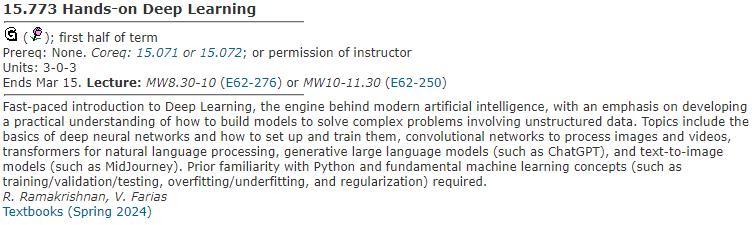

In [ ]:
mit_course_data[mit_course_data.course_name == '15.773 Hands-on Deep Learning']

,course_name,description
334,15.773 Hands-on Deep Learning,"Graduate Spring Coreq: 15.071 or 15.072 MW8.30-10 MW10-11.30 R. Ramakrishnan, V. Farias ( ); first half of term Prereq: None. ; or permission of instructor Units: 3-0-3 Ends Mar 14. ( ) or ( ) Fast-paced introduction to Deep Learning, the engine behind modern artificial intelligence, with an emphasis on developing a practical understanding of how to build models to solve complex problems..."


# Manually Prompting GPT.

To help the model answer a question, we can provide relevant custom data **in the prompt itself**. This extra information we provide in the prompt is referred to as **context**. The idea is that we will pass into ChatGPT a query of the follow form:

```
Instructions: Use the context provided to answer the following question.

Context: <Very Long String>

Question: Who are the instructors of 15.773?
```

First, let me take all of the text from all 400+ Sloan courses and concatenate them together into one long string `all_mit_source_info`.

In [ ]:
mit_course_data['text'] = mit_course_data['course_name'] + ' ' + 'Course Info: ' + mit_course_data['description']

all_mit_course_info = "\n\n".join(mit_course_data['text'])
print(all_mit_course_info[:10000])

15.000 Explorations in Management Course Info: Undergrad Fall J. Orlin   ( ) Prereq: None Units: 2-0-1 [P/D/F]  Broad introduction to the various aspects of management including analytics, accounting and finance, operations, marketing, entrepreneurship and leadership, organizations, economics, systems dynamics, and negotiation and communication. Introduces the field of management through a variety of experiences as well as discussions led by faculty or industry experts. Also reviews the three undergraduate majors offered by Sloan as well as careers in management. Subject can count toward the 6-unit discovery-focused credit limit for first year students. Limited to undergraduates; preference to first years.  

15.002 Leadership Challenges for an Inclusive World Course Info: Graduate Fall Spring TBA Consult: Sloan Educational Services Consult: Sloan Educational Services   ( , ) Prereq: None Units arranged [P/D/F]     Units assigned to MBA students upon completion. Restricted to Sloan MBA

We could try passing in this string as the context for each of our questions above. But that will not work. Why?

Answer: GPT 3 Turbo has a token limit of 16,385. See this [link](https://platform.openai.com/docs/models/gpt-3-5-turbo) for details. The text above greatly exceeds that limit. Let's see how many tokens it has:

In [ ]:
def num_tokens(text: str, model: str = GPT_MODEL) -> int:
    """Return the number of tokens in a string."""
    encoding = tiktoken.encoding_for_model(model)
    return len(encoding.encode(text))

print('Number of Characters:', len(all_mit_course_info))
print('Number of Tokens:', num_tokens(all_mit_course_info))

Number of Characters: 334143
Number of Tokens: 66144


That is far more tokens than GPT3 Turbo can handle! Note that GPT4 is able to handle more tokens than GPT3, but let's stick with GPT3 for demonstration purposes. Also GPT3 is much cheaper than GPT4 to use OpenAI's API.

To reduce the token length, let's divide `all_mit_course_info` into substrings of length say 50,000.

We will pass a single chunk of length 50,000 into GPT3, which should be significantly under the token limit. To decide _which_ of the many length 50,000 chunks we should pass in, let's just use a keyword.

We will do the following. Let's divide the

In [ ]:
CHUNK_SIZE = 50000

query_word = 'Deep Learning'

chunk_idx = None

for i in range(10):
    if query_word in all_mit_course_info[i * CHUNK_SIZE: (i+1) * CHUNK_SIZE]:
        chunk_idx = i
        print("Found keyword '%s' in chunk %d" % (query_word, chunk_idx))
        break

Found keyword 'Deep Learning' in chunk 5


In [ ]:
query = f"""Use the below information on courses at the MIT Sloan School of Management
to answer the subsequent question.

Article:
```
{all_mit_course_info[chunk_idx * CHUNK_SIZE: (chunk_idx+1) * CHUNK_SIZE]}
```

Question: Who are the instructors of Hands-On Deep Learning?"""

response = client.chat.completions.create(
    messages=[
        {'role': 'system', 'content': 'You answer questions about the MIT Sloan Courses.'},
        {'role': 'user', 'content': query},
    ],
    model=GPT_MODEL,
    temperature=0,
)

print(response.choices[0].message.content)

The instructors of the course "Hands-on Deep Learning" (15.773) are R. Ramakrishnan and V. Farias.


In [ ]:
query = f"""Use the below information on courses at the MIT Sloan School of Management
to answer the subsequent question.

Article:
```
{all_mit_course_info[chunk_idx * CHUNK_SIZE: (chunk_idx+1) * CHUNK_SIZE]}
```

Question: What course should I take if I want to learn more about deep learning? Please give me the course number"""

response = client.chat.completions.create(
    messages=[
        {'role': 'system', 'content': 'You answer questions about the MIT Sloan Courses.'},
        {'role': 'user', 'content': query},
    ],
    model=GPT_MODEL,
    temperature=0,
)

print(response.choices[0].message.content)

You should take the course **15.773 Hands-on Deep Learning** if you want to learn more about deep learning.


Take a moment to notice what the prompt has grown to.


OK, let's run it.

In [ ]:
print(query)

Use the below information on courses at the MIT Sloan School of Management
to answer the subsequent question.

Article:
```
ut co-payment (up to $500) may be necessary. Restricted to Leaders for Global Operations students. No textbook information available 

15.768 Management of Services: Creating Value for Customers, Employees, and Investors Course Info: Graduate Fall Coreq: 15.761 or 15.778 Z. Ton   ( ) Prereq: None.  Units: 3-0-6  Focuses on how companies can use operational principles to create value for customers, employees, and investors simultaneously. Case-based subject that emphasizes systems perspective and leadership in operations versus the use of specific analytical tools (e.g., queuing theory, inventory management, process analysis) that were covered in the pre- or co-requisite. Cases include a range of service operations contexts including healthcare, hospitality, retailing, food service, pest control, and financial services.  

15.769 Operations Strategy Course Info: Gr

Nicely done, `gpt-3.5-turbo`!


# Retrieval Augmented Generation (RAG)

In the previous section, we got around GPT3's 16,385 token limit by dividing our course information text into chunks of smaller size and using only the chunk that contained the word 'Deep Learning'.

RAG is essentially an automatic way of doing this. Given the question, RAG examines the course catalog and determines which course descriptions to use based on a similar score. For example, if the question mentions deep learning, then RAG will likely construct a context full of courses related to deep learning, but not necessarily need to have the word "deep learning" exactly.




**RETRIEVAL AUGMENTED GENERATION**

**One-time setup**
* Preprocess the custom dataset by splitting it into 'sections'
* We calculate an embedding vector for each section using the `text-embedding-ada-002` model and store it somewhere handy


**Each time we receive a question, we do this:**
* We calculate an embedding vector for the question (again using the same `text-embedding-ada-002` model)
* For each section in our custom dataset, we calculate the *cosine similarity* (more or less the dot-product) between that section's embedding vector and the question's embedding vector
* We rank the sections from most-cosine-similar to the question to least-cosine-similar
* Starting from the most-cosine-similar section, include as many sections into the prompt as can fit into the context window
* Send the prompt into `gpt-3.5-turbo`.

![RAG](https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F4063347e-8920-40c6-86b3-c520084b303c_1272x998.jpeg)

Credit for 👆image: https://magazine.sebastianraschka.com/p/finetuning-large-language-models


Our data can be broken up into very natural sectinos based on the courses.

In [ ]:
mit_course_data

,course_name,description,text
0,15.000 Explorations in Management,"Undergrad Fall J. Orlin ( ) Prereq: None Units: 2-0-1 [P/D/F] Broad introduction to the various aspects of management including analytics, accounting and finance, operations, marketing, entrepreneurship and leadership, organizations, economics, systems dynamics, and negotiation and communication. Introduces the field of management through a variety of experiences as well as discussions led ...","15.000 Explorations in Management Course Info: Undergrad Fall J. Orlin ( ) Prereq: None Units: 2-0-1 [P/D/F] Broad introduction to the various aspects of management including analytics, accounting and finance, operations, marketing, entrepreneurship and leadership, organizations, economics, systems dynamics, and negotiation and communication. Introduces the field of management through a var..."
1,15.002 Leadership Challenges for an Inclusive World,"Graduate Fall Spring TBA Consult: Sloan Educational Services Consult: Sloan Educational Services ( , ) Prereq: None Units arranged [P/D/F] Units assigned to MBA students upon completion. Restricted to Sloan MBA students. Fall: Spring: No textbook information available","15.002 Leadership Challenges for an Inclusive World Course Info: Graduate Fall Spring TBA Consult: Sloan Educational Services Consult: Sloan Educational Services ( , ) Prereq: None Units arranged [P/D/F] Units assigned to MBA students upon completion. Restricted to Sloan MBA students. Fall: Spring: No textbook information available"
2,15.003 Analytics Tools,"Graduate Fall IAP Summer M. Li M. Li M. Li ( , , ) Prereq: None Units: 2-0-1 [P/D/F] Units assigned to Master of Business Analytics students upon completion of the Analytics Tools requirement. Restricted to Master of Business Analytics students. Fall: IAP: Summer: No textbook information available","15.003 Analytics Tools Course Info: Graduate Fall IAP Summer M. Li M. Li M. Li ( , , ) Prereq: None Units: 2-0-1 [P/D/F] Units assigned to Master of Business Analytics students upon completion of the Analytics Tools requirement. Restricted to Master of Business Analytics students. Fall: IAP: Summer: No textbook information available"
3,15.004 Programming for Finance Professionals,"Graduate Summer B. Vartak ( ) Prereq: None Units: 1-0-0 [P/D/F] Two-day accelerated course with supplemental recitations designed to develop skills in applying basic methods from the programming language Python (with additional references from R) to financial problems. Topics include programming basics in Python, data manipulation, visualization and reporting and an overview of programming ...","15.004 Programming for Finance Professionals Course Info: Graduate Summer B. Vartak ( ) Prereq: None Units: 1-0-0 [P/D/F] Two-day accelerated course with supplemental recitations designed to develop skills in applying basic methods from the programming language Python (with additional references from R) to financial problems. Topics include programming basics in Python, data manipulation, v..."
4,15.005 Sloan Intensive Period Elective Requirement,Graduate Spring Consult: Sloan Educational Services ( ); second half of term Prereq: Units arranged [P/D/F] URL: TBA. Units assigned to MBA students upon completion of the Sloan Intensive Period (SIP) elective requirement. Restricted to Sloan MBA students. No textbook information available,15.005 Sloan Intensive Period Elective Requirement Course Info: Graduate Spring Consult: Sloan Educational Services ( ); second half of term Prereq: Units arranged [P/D/F] URL: TBA. Units assigned to MBA students upon completion of the Sloan Intensive Period (SIP) elective requirement. Restricted to Sloan MBA students. No textbook information available
...,...,...,...
457,15.960 Independent Study in Management,"Graduate Fall IAP Spring Summer Can be repeated for credit C. Beck C. Beck C. Beck C. Beck ( , , , ) Prereq: Permission of instructor Units arranged [P/D/F] TBA. Advanced work, special investigation or applic

Next, we define a function to calculate the embedding using the `text-embedding-ada-002` model, given a piece of text. The API call is simple (see below). [Link](https://openai.com/blog/new-and-improved-embedding-model).

In [ ]:
def get_embedding(text: str, model: str=EMBEDDING_MODEL) -> list[float]:
    result = client.embeddings.create(
      model=EMBEDDING_MODEL,  # which embedding model we want to use
      input=text,            # feed in the text for which you want to calc the embedding
    )
    return result.data[0].embedding

def compute_doc_embeddings_from_column(df: pd.DataFrame, column_name: str) -> dict[tuple[str, str], list[float]]:
    """
    Takes a column of df and create an embedding for each row in the dataframe using the OpenAI Embeddings API.

    Return a dictionary that maps between each embedding vector and the index of the row that it corresponds to.
    """
    return {
        idx: get_embedding(r[column_name]) for idx, r in df.iterrows()
    }

mit_embeddings = compute_doc_embeddings_from_column(mit_course_data, 'text')
mit_course_data['embeddings'] = mit_embeddings
mit_course_data.to_csv('mit_course_data.csv', index=False)
mit_course_data.head()

,course_name,description,text,embeddings
0,15.000 Explorations in Management,"Undergrad Fall J. Orlin ( ) Prereq: None Units: 2-0-1 [P/D/F] Broad introduction to the various aspects of management including analytics, accounting and finance, operations, marketing, entrepreneurship and leadership, organizations, economics, systems dynamics, and negotiation and communication. Introduces the field of management through a variety of experiences as well as discussions led ...","15.000 Explorations in Management Course Info: Undergrad Fall J. Orlin ( ) Prereq: None Units: 2-0-1 [P/D/F] Broad introduction to the various aspects of management including analytics, accounting and finance, operations, marketing, entrepreneurship and leadership, organizations, economics, systems dynamics, and negotiation and communication. Introduces the field of management through a var...","[0.010812425054609776, -0.020634502172470093, 0.01254892535507679, -0.015275772660970688, -0.03700915351510048, 0.027241341769695282, -0.0357067808508873, 0.0008987743640318513, -0.017554929479956627, -0.019617022946476936, -0.0001553777401568368, 0.021923311054706573, 0.009754245169460773, 0.025464143604040146, 0.0021740165539085865, -0.013844517059624195, 0.003608663799241185, -0.02581686899..."
1,15.002 Leadership Challenges for an Inclusive World,"Graduate Fall Spring TBA Consult: Sloan Educational Services Consult: Sloan Educational Services ( , ) Prereq: None Units arranged [P/D/F] Units assigned to MBA students upon completion. Restricted to Sloan MBA students. Fall: Spring: No textbook information available","15.002 Leadership Challenges for an Inclusive World Course Info: Graduate Fall Spring TBA Consult: Sloan Educational Services Consult: Sloan Educational Services ( , ) Prereq: None Units arranged [P/D/F] Units assigned to MBA students upon completion. Restricted to Sloan MBA students. Fall: Spring: No textbook information available","[-0.0008060497348196805, -0.0182932298630476, -0.011025120504200459, -0.021052926778793335, -0.02814343199133873, 0.02057476155459881, -0.004105388652533293, 0.007568670436739922, -0.02713245339691639, -0.022118551656603813, 0.009310557506978512, 0.015041708014905453, 0.0013542318483814597, 0.01562916673719883, 0.017746755853295326, -0.008354227058589458, 0.006407412234693766, -0.0363951958715..."
2,15.003 Analytics Tools,"Graduate Fall IAP Summer M. Li M. Li M. Li ( , , ) Prereq: None Units: 2-0-1 [P/D/F] Units assigned to Master of Business Analytics students upon completion of the Analytics Tools requirement. Restricted to Master of Business Analytics students. Fall: IAP: Summer: No textbook information available","15.003 Analytics Tools Course Info: Graduate Fall IAP Summer M. Li M. Li M. Li ( , , ) Prereq: None Units: 2-0-1 [P/D/F] Units assigned to Master of Business Analytics students upon completion of the Analytics Tools requirement. Restricted to Master of Business Analytics students. Fall: IAP: Summer: No textbook information available","[0.008854861371219158, -0.010965164750814438, 0.016573945060372353, -0.03323202207684517, -0.03584010526537895, 0.019196050241589546, -0.029277831315994263, 0.005692911799997091, 0.01587284728884697, -0.03881275653839111, 0.017920052632689476, 0.021453583613038063, 0.007684028707444668, 0.024454280734062195, 0.0039787283167243, -0.017485370859503746, -0.0012567172525450587, -0.0040383213199675..."
3,15.004 Programming for Finance Professionals,"Graduate Summer B. Vartak ( ) Prereq: None Units: 1-0-0 [P/D/F] Two-day accelerated course with supplemental recitations designed to develop skills in applying basic methods from the programming language Python (with additional references from R) to financial problems. Topics include programming basics in Python, data manipulation, visualization and reporting and an overview of programming ...","15.004 Programming for Finance Professionals Course Info: Graduate Summer B. Vartak ( ) Prereq: None Units: 1-0-0 [P/D/F] Two-day accelerated course

So we have a custom data-set split into sections, and embedding vectors calculated for each. We also have a function that can calculate the embedding for any question.

Next we will use these embeddings to answer our users' questions.


Each time we receive a question

* We calculate an embedding vector for the question with the `get_embedding` funtion we defined above.
* For each chunk in our custom dataset, we calculate the cosine similarity between that chunk's embedding vector and the question's embedding vector
* We rank the sections from most-cosine-similar to the question to least-cosine-similar

We first define a couple of helper functions.

In [ ]:
from IPython import embed
from scipy import spatial

# search function
def strings_ranked_by_relatedness(
    query: str,
    df: pd.DataFrame,
    relatedness_fn=lambda x, y: 1 - spatial.distance.cosine(x, y),
    top_n: int = 100
) -> tuple[list[str], list[float]]:

    """Returns a list of strings and relatednesses, sorted from most related to least."""

    query_embedding = get_embedding(query) # bug fixed

    strings_and_relatednesses = [
        (row["text"], relatedness_fn(query_embedding, row["embeddings"]))
        for i, row in df.iterrows()
    ]
    strings_and_relatednesses.sort(key=lambda x: x[1], reverse=True)
    strings, relatednesses = zip(*strings_and_relatednesses)
    return strings[:top_n], relatednesses[:top_n]

Let's examine this function to see what it pulls up as documents most similar to the query string "deep learning"

In [ ]:
strings, relatednesses = strings_ranked_by_relatedness("Who teaches hands-on deep learning?", mit_course_data, top_n=5)
for string, relatedness in zip(strings, relatednesses):
    print(f"***{relatedness=:.3f}***")
    display(string)
    print('\n')

***relatedness=0.865***


'15.773 Hands-on Deep Learning Course Info: Graduate Spring Coreq: 15.071 or 15.072 MW8.30-10 MW10-11.30 R. Ramakrishnan, V. Farias   ( ); first half of term Prereq: None. ; or permission of instructor Units: 3-0-3 Ends Mar 14.  ( ) or ( )    Fast-paced introduction to Deep Learning, the engine behind modern artificial intelligence, with an emphasis on developing a practical understanding of how to build models to solve complex problems involving unstructured data. Topics include the basics of deep neural networks and how to set up and train them, convolutional networks to process images and videos, transformers for natural language processing, generative large language models (such as ChatGPT), and text-to-image models (such as MidJourney). Prior familiarity with Python and fundamental machine learning concepts (such as training/validation/testing, overfitting/underfitting, and regularization) required.  '



***relatedness=0.812***


'15.572 Analytics Lab: Action Learning Seminar on Analytics, Machine Learning, and the Digital Economy Course Info: Graduate Fall S. Aral, A. Almaatouq   ( ) Prereq: Permission of instructor Units: 2-0-7  Student teams design and deliver a project based on the use of analytics, machine learning, large data sets, or other digital innovations to create or transform a business or other organization. Teams may be paired up with an organization or propose their own ideas and sites for the project. Culminates with presentation of results to an audience that includes IT experts, entrepreneurs, and executives.  '



***relatedness=0.800***


'15.076 Analytics for a Better World Course Info: Undergrad Spring Institute Lab MW11.30-1 F11.30 +final D. Bertsimas   ( )  Prereq:  Units: 4-0-8  ( )  ( )    Introduces predictive and prescriptive analytics methods to solve problems that contribute to the welfare of society. Emphasis on using machine learning and optimization methods in innovative ways using real world data. Methods used include: linear and discrete optimization, linear and logistic regression, optimal classification and regression trees, deep learning, random forests, and boosted trees. Projects utilize Julia, Jump, and Tensor Flow. Assessment based on projects, including a capstone project. Restricted to undergraduates.  '



***relatedness=0.799***


'15.238[J] Shaping the Future of Technology:  From Early Agriculture to Artificial Intelligence Course Info: Not offered academic year 2024-2025 Undergrad Spring HASS Social Sciences Communication Intensive HASS D. Acemoglu, S. Johnson   ( )   (Same subject as ) Prereq: None Units: 4-0-8  Provides a framework for thinking about major technological transitions over the past 12,000 years as a means to explore paths to a better future. Discusses who gains or loses from innovation and who can shape the future of artificial intelligence, biotech, and other breakthroughs. Introduces major questions tackled by researchers and relevant to economic policy through faculty lectures, interactive events with prominent guests, and group work. Instruction and practice in oral and written communication provided.  '



***relatedness=0.799***


'15.095 Machine Learning Under a Modern Optimization Lens Course Info: Graduate Fall K. Villalobos Carballo   ( ) Prereq: , , or permission of instructor Units: 3-1-8  Develops algorithms for central problems in machine learning from a modern optimization perspective. Topics include sparse, convex, robust and median regression; an algorithmic framework for regression; optimal classification and regression trees, and their relationship with neural networks; how to transform predictive algorithms to prescriptive algorithms; optimal prescriptive trees; and robust classification.\xa0 Also covers design of experiments, missing data imputations, mixture of Gaussian models, exact bootstrap, and sparse matrix estimation, including principal component analysis, factor analysis, inverse co-variance matrix estimation, and matrix completion.  '

Now, we write a function `query_messsage` which constructs a prompt for GPT given a query. The function produces a query in the following format.

```
Use the below course catalog from MIT Sloan to answer the subsequent questions

Course descrpiption section: ...

Course description section: ...

...

Course description section: ...

Question: What are some courses in deep learning at MIT Sloan?
```

Note that the prompt starts with a sentence asking GPT to use the below course catalog. It then proceeds to list courses the are relevant (using the embedding and cosine similarity). Finally, the question we are interested in is written.

In [ ]:
import tiktoken  # for counting tokens

def num_tokens(text: str, model: str = GPT_MODEL) -> int:
    """Return the number of tokens in a string."""
    encoding = tiktoken.encoding_for_model(model)
    return len(encoding.encode(text))

def query_message(
    query: str,
    df: pd.DataFrame,
    model: str,
    token_budget: int
) -> str:
    """Return a message for GPT, with relevant source texts pulled from a dataframe."""
    strings, relatednesses = strings_ranked_by_relatedness(query, df)
    message = "Use the below course catalog from MIT Sloan to answer the subsequent question. "

    question = f"\n\nQuestion: {query}"

    for string in strings:
        next_article = f'\nCourse description section: {string}\n'
        if (
            num_tokens(message + next_article + question, model=model)
            > token_budget
        ):
            break
        else:
            message += next_article
    return message + question

Query message first begins with the `HEADER` and then pulls the related articles sorted in descending order of similarity to the query. We then add these articles to the query until the token budget is consumed. Below we pass in our query about 2022 curling with a token budget of 3700 tokens. We could go higher (how much higher?) but OpenAI charges by the token 😰



In [ ]:
query = query_message("'What course at MIT sloan are about deep learning?", mit_course_data, GPT_MODEL, 3700)

print(query)

Use the below course catalog from MIT Sloan to answer the subsequent question. 
Course description section: 15.773 Hands-on Deep Learning Course Info: Graduate Spring Coreq: 15.071 or 15.072 MW8.30-10 MW10-11.30 R. Ramakrishnan, V. Farias   ( ); first half of term Prereq: None. ; or permission of instructor Units: 3-0-3 Ends Mar 14.  ( ) or ( )    Fast-paced introduction to Deep Learning, the engine behind modern artificial intelligence, with an emphasis on developing a practical understanding of how to build models to solve complex problems involving unstructured data. Topics include the basics of deep neural networks and how to set up and train them, convolutional networks to process images and videos, transformers for natural language processing, generative large language models (such as ChatGPT), and text-to-image models (such as MidJourney). Prior familiarity with Python and fundamental machine learning concepts (such as training/validation/testing, overfitting/underfitting, and r

Now let's write the question which will pass the above prompt to GPT for a response.


In [ ]:
def ask(
    query: str,
    df: pd.DataFrame = mit_course_data,
    model: str = GPT_MODEL,
    token_budget: int = 4096 - 500,
) -> str:
    """Answers a query using GPT and a dataframe of relevant texts and embeddings."""
    message = query_message(query, df, model=model, token_budget=token_budget)

    messages = [
        {"role": "system", "content": "You answer questions about MIT Sloan Courses."},
        {"role": "user", "content": message},
    ]

    response = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=0
    )
    response_message = response.choices[0].message.content
    return response_message

 Send the query into `gpt-3.5-turbo`!

Now that we've retrieved the relevant sections and constructed our prompt, we can finally answer the user's query.

In [ ]:
print(ask('What are some courses at MIT Sloan on operations research or operations management? Please list them with their instructors.'))

Here are some courses at MIT Sloan focused on operations research or operations management, along with their instructors:

1. **15.799 Workshop in Operations Management**
   - Instructors: D. Freund, T. Lykouris

2. **15.734 Introduction to Operations Management**
   - Instructor: R. Levi

3. **15.784 Operations Laboratory**
   - Instructor: T. Roemer

4. **15.774 The Analytics of Operations Management**
   - Instructor: M. Fazel Zarandi

5. **15.099 Seminar in Operations Research**
   - Instructor: Staff

6. **15.090 Common Experience in Operations Research**
   - Instructors: T. Lykouris, C. Podimata

7. **15.761 Introduction to Operations Management**
   - Instructors: R. Levi, N. Trichakis, T. Lykouris, S. Willems

8. **15.7611 Introduction to Operations Management**
   - Instructors: N. Trichakis, T. Lykouris

9. **15.778 Introduction to Operations Management**
   - Instructor: V. Farias

10. **15.764[J] The Theory of Operations Management**
    - Instructor: D. Freund

11. **15.7

In [ ]:
print(ask('Which courses are taught by R. Ramakrishnan? Please list them and the semester they are offered in.'))

The courses taught by R. Ramakrishnan and the semesters they are offered in are:

1. **15.375[J] Global Ventures** - Offered in Fall.
2. **15.072 Advanced Analytics Edge** - Offered in Fall.
3. **15.773 Hands-on Deep Learning** - Offered in Spring.


In [ ]:
print(ask('Are there any co-requisites to Hands-On Deep Learning?'))

Yes, the course 15.773 Hands-on Deep Learning has co-requisites of 15.071 or 15.072.


# RAG + Few Shot Prompting

Let's look at the following question.

In [ ]:
print(ask('How many units is 15.773'))

The course 15.773, Hands-on Deep Learning, has a unit structure of 3-0-3.


Hmm ... this is not quite correct. 15.773 is a 6-unit class. The reason GPT cannot answer this correctly is that in the course catalog, the Units is given as three numbers: `3-0-3`. GPT does not know that the total number of units should be the sum of these three numbers. How can we tell GPT this?

Let's add some few-shot learning to the prompt! We will augment the prompt from above as follows:


```
Use the below course catalog from MIT Sloan to answer the subsequent questions.
If the question pertains to the number of credits or units in a course,
you need to add the numbers in the course description.
For example, if the units are 3-0-6, you should add 3 + 0 + 6 and provide 9
as the answer. If the units are 1-2-3, you should provide 6 as the answer.

Course descrpiption section: ...

Course description section: ...

...

Course description section: ...

Question: What are some courses in deep learning at MIT Sloan?
```



In [ ]:
def query_message_with_units(
    query: str,
    df: pd.DataFrame,
    model: str,
    token_budget: int
) -> str:
    strings, relatednesses = strings_ranked_by_relatedness(query, df)
    message = "Use the below course catalog from MIT Sloan to answer the subsequent question.\n \
    If the question pertains to the number of credits or units in a course, you need \
    to add the numbers in the course description. For example, if the units are \
    3-0-6, you should add 3 + 0 + 6 and provide 9 as the answer. \
    If the units are 1-2-3, you should provide 6 as the answer."

    question = f"\n\nQuestion: {query}"

    for string in strings:
        next_article = f'\n\nCourse description section:\n"""\n{string}\n"""'
        if (
            num_tokens(message + next_article + question, model=model)
            > token_budget
        ):
            break
        else:
            message += next_article
    return message + question

def ask_with_units(
    query: str,
    df: pd.DataFrame = mit_course_data,
    model: str = GPT_MODEL,
    token_budget: int = 4096 - 500,
) -> str:
    """Answers a query using GPT and a dataframe of relevant texts and embeddings."""
    message = query_message_with_units(query, df, model=model, token_budget=token_budget)

    messages = [
        {"role": "system", "content": "You answer questions about MIT Sloan Courses."},
        {"role": "user", "content": message},
    ]

    response = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=0
    )
    response_message = response.choices[0].message.content
    return response_message

In [ ]:
print(ask_with_units('For each of the classes The Analytics Edge, Data Models \
 and Decisions and Hands-On Deep Learning, please list the number of units'))

Here are the number of units for each of the specified classes:

1. **The Analytics Edge (15.0711)**: 4-0-8 → 4 + 0 + 8 = **12 units**
2. **The Analytics Edge (15.071)**: 4-0-8 → 4 + 0 + 8 = **12 units**
3. **Data, Models, and Decisions (15.060)**: 3-0-6 → 3 + 0 + 6 = **9 units**
4. **Data, Models, and Decisions (15.730)**: 3-0-6 → 3 + 0 + 6 = **9 units**
5. **Hands-on Deep Learning (15.773)**: 3-0-3 → 3 + 0 + 3 = **6 units**

So, the units are:
- The Analytics Edge (15.0711): 12 units
- The Analytics Edge (15.071): 12 units
- Data, Models, and Decisions (15.060): 9 units
- Data, Models, and Decisions (15.730): 9 units
- Hands-on Deep Learning (15.773): 6 units
